In [1]:
# MLP Training Pipeline with Optuna + 5-Fold CV + Final Test Evaluation
# Assumes: feature_vectors.h5 (with sample IDs), labels.csv (with ID, LABEL)

import h5py
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import optuna
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn import metrics
import random

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# ----------------------------
# Dataset Wrapper
# ----------------------------
class SlideFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [3]:
# ----------------------------
# MLP Model with Residuals + Two-Head Output
# ----------------------------
class ResidualMLP(nn.Module):
    def __init__(self, input_dim, hidden_units, num_layers, dropout_rate, activation):
        super().__init__()
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.activation = getattr(nn, activation)()

        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_units
            self.layers.append(nn.Linear(in_dim, hidden_units))
            self.norms.append(nn.BatchNorm1d(hidden_units))
            self.dropouts.append(nn.Dropout(dropout_rate))

        self.out = nn.Linear(hidden_units, 2)  # Two logits for softmax

    def forward(self, x):
        for layer, norm, dropout in zip(self.layers, self.norms, self.dropouts):
            residual = x
            x = dropout(self.activation(norm(layer(x))))
            if x.shape == residual.shape:
                x = x + residual  # residual connection
        return self.out(x)

In [4]:
# ----------------------------
# Utility: Load Data
# ----------------------------
def load_data(h5_path, label_path):
    df = pd.read_csv(label_path)
    with h5py.File(h5_path, 'r') as h5f:
        features = []
        labels = []
        for idx, row in df.iterrows():
            sample_id = str(row['H5_Key'])
            if sample_id in h5f:
                features.append(h5f[sample_id][:])
                labels.append(row['FGFR3_MUTATION_PRESENT'])
    return np.vstack(features), np.array(labels)

In [7]:
# ----------------------------
# Optuna Objective
# ----------------------------
def objective(trial):
    hidden_units = trial.suggest_categorical("hidden_units", [ 64, 128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 2, 7)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    activation = trial.suggest_categorical("activation", ["ReLU", "GELU"])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]


        train_ds = SlideFeatureDataset(X_tr, y_tr)
        val_ds = SlideFeatureDataset(X_val, y_val)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,drop_last=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = ResidualMLP(512, hidden_units, num_layers, dropout_rate, activation)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(100):  # Fixed number of epochs
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                out = model(xb)
                prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
                all_preds.extend(prob)
                all_targets.extend(yb.numpy())
        auc = roc_auc_score(all_targets, all_preds)
        aucs.append(auc)

    return np.mean(aucs)

[I 2025-08-04 13:51:18,473] A new study created in memory with name: no-name-2eebf49e-6e4c-4162-a392-b0d5b0446b2b


=== Repetition 1/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:51:22,545] Trial 0 finished with value: 0.771907469342252 and parameters: {'hidden_units': 64, 'num_layers': 4, 'dropout_rate': 0.37331822741926135, 'lr': 6.251043787171314e-05, 'weight_decay': 0.04193131117117021, 'batch_size': 16, 'activation': 'GELU'}. Best is trial 0 with value: 0.771907469342252.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:51:25,652] Trial 1 finished with value: 0.800680044593088 and parameters: {'h

=== Repetition 2/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:54:47,435] Trial 0 finished with value: 0.7852675585284281 and parameters: {'hidden_units': 256, 'num_layers': 4, 'dropout_rate': 0.39442400102106645, 'lr': 5.772477519462199e-05, 'weight_decay': 0.07702315501753043, 'batch_size': 64, 'activation': 'ReLU'}. Best is trial 0 with value: 0.7852675585284281.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:54:49,331] Trial 1 finished with value: 0.7365183946488294 and parameters:

=== Repetition 3/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:56:56,572] Trial 0 finished with value: 0.6769554069119288 and parameters: {'hidden_units': 256, 'num_layers': 2, 'dropout_rate': 0.25625361742657354, 'lr': 1.00241669286155e-05, 'weight_decay': 0.06261491161350417, 'batch_size': 64, 'activation': 'GELU'}. Best is trial 0 with value: 0.6769554069119288.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:56:58,541] Trial 1 finished with value: 0.7641872909698997 and parameters: 

=== Repetition 4/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:59:46,355] Trial 0 finished with value: 0.7921638795986622 and parameters: {'hidden_units': 64, 'num_layers': 2, 'dropout_rate': 0.17799759618215602, 'lr': 6.498717644620553e-05, 'weight_decay': 0.045018384798609895, 'batch_size': 32, 'activation': 'ReLU'}. Best is trial 0 with value: 0.7921638795986622.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 13:59:52,443] Trial 1 finished with value: 0.8000222965440358 and parameters:

=== Repetition 5/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:02:22,654] Trial 0 finished with value: 0.8038049052396877 and parameters: {'hidden_units': 64, 'num_layers': 2, 'dropout_rate': 0.2905984327247936, 'lr': 7.753562044848519e-05, 'weight_decay': 0.09958073089425601, 'batch_size': 16, 'activation': 'ReLU'}. Best is trial 0 with value: 0.8038049052396877.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:02:27,281] Trial 1 finished with value: 0.7969163879598663 and parameters: {

=== Repetition 6/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:04:48,932] Trial 0 finished with value: 0.7508874024526199 and parameters: {'hidden_units': 512, 'num_layers': 4, 'dropout_rate': 0.4330194498784613, 'lr': 0.00441360900290048, 'weight_decay': 0.04325350764976237, 'batch_size': 64, 'activation': 'GELU'}. Best is trial 0 with value: 0.7508874024526199.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:04:50,208] Trial 1 finished with value: 0.8093121516164994 and parameters: {'

=== Repetition 7/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:06:19,421] Trial 0 finished with value: 0.7433166109253065 and parameters: {'hidden_units': 64, 'num_layers': 4, 'dropout_rate': 0.31036369245039486, 'lr': 0.0036900903633696126, 'weight_decay': 0.011633547092263032, 'batch_size': 16, 'activation': 'GELU'}. Best is trial 0 with value: 0.7433166109253065.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:06:21,893] Trial 1 finished with value: 0.778561872909699 and parameters: 

=== Repetition 8/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:08:38,133] Trial 0 finished with value: 0.760701226309922 and parameters: {'hidden_units': 256, 'num_layers': 6, 'dropout_rate': 0.22380728796693694, 'lr': 0.00010801645761677525, 'weight_decay': 0.04281718672800383, 'batch_size': 64, 'activation': 'GELU'}. Best is trial 0 with value: 0.760701226309922.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:08:39,720] Trial 1 finished with value: 0.8012686733556299 and parameters: 

=== Repetition 9/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:10:41,812] Trial 0 finished with value: 0.7276254180602006 and parameters: {'hidden_units': 256, 'num_layers': 4, 'dropout_rate': 0.4259552066442137, 'lr': 0.009402925356530124, 'weight_decay': 0.05118734594536082, 'batch_size': 64, 'activation': 'ReLU'}. Best is trial 0 with value: 0.7276254180602006.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:10:43,370] Trial 1 finished with value: 0.759752508361204 and parameters: {'

=== Repetition 10/10 ===


/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:12:32,768] Trial 0 finished with value: 0.7430468227424749 and parameters: {'hidden_units': 512, 'num_layers': 4, 'dropout_rate': 0.42130009888512965, 'lr': 0.0006915940777945065, 'weight_decay': 0.0026110174924871667, 'batch_size': 64, 'activation': 'GELU'}. Best is trial 0 with value: 0.7430468227424749.
/tmp/ipykernel_21868/2478736254.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
[I 2025-08-04 14:12:34,023] Trial 1 finished with value: 0.7941917502787068 and parameter

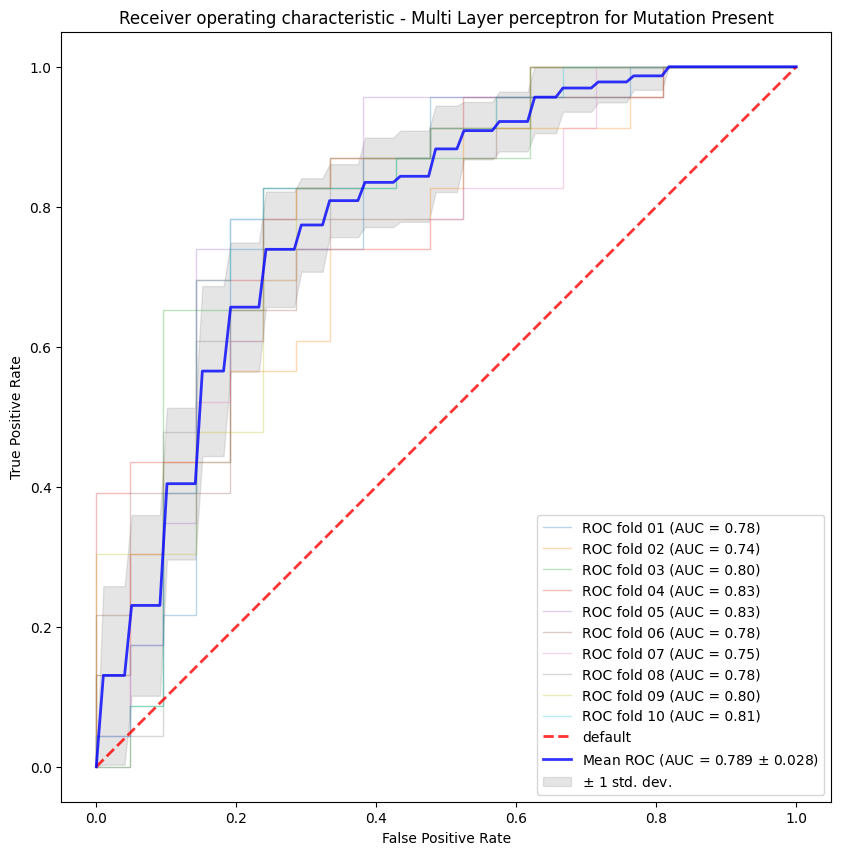

In [8]:
# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, y = load_data("/home/mxn477/m07/eagle/EAGLE/output/features/2mpp/eagle/chief_tcga_crc.h5", "label_lookup.csv")
    fig, ax = plt.subplots(1,1,figsize=((1)*11,10))
    mean_fpr = np.linspace(0, 1, 100)
    all_tprs = []
    all_aucs = []
    raw_curves = []  # FPR, TPR of best model
    det_curve = None
    n_repeats=10   # 10 Trials
    # Iteration for each trial
    for i in range(n_repeats):
        print(f"=== Repetition {i+1}/{n_repeats} ===")
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=2)
    
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=50, show_progress_bar=False)
        best_params = study.best_trial.params
        # Train best model
        X_tr_scaled = X_train
        X_te_scaled = X_test
    
        train_ds = SlideFeatureDataset(X_tr_scaled, y_train)
        test_ds = SlideFeatureDataset(X_te_scaled, y_test)
        train_loader = DataLoader(train_ds, batch_size=best_params['batch_size'], shuffle=True,drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=best_params['batch_size'], shuffle=False)
    
        model = ResidualMLP(512, best_params['hidden_units'], best_params['num_layers'],
                            best_params['dropout_rate'], best_params['activation'])
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    
        for epoch in range(100):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
    
        # Test evaluation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                out = model(xb)
                prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
                all_preds.extend(prob)
                all_targets.extend(yb.numpy())
        local_ax = None
        if det_curve:
            local_ax = det_curve.ax_
        else:
            local_ax = ax
        det_curve = metrics.RocCurveDisplay.from_predictions(
                        all_targets ,
                        all_preds,
                        name='ROC fold {}'.format(str(i+1).zfill(2)),
                        pos_label = 1,
                        alpha=0.3, 
                        lw=1, 
                        ax=local_ax,
         )
        local_ax = det_curve.ax_    
        
        fpr, tpr, _ = roc_curve(all_targets, all_preds)      
        auc = roc_auc_score(all_targets, all_preds)
        
        raw_curves.append((fpr, tpr))
        interp_tpr = np.interp(mean_fpr, det_curve.fpr, det_curve.tpr)
        interp_tpr[0] = 0.0
        all_tprs.append(interp_tpr)
        all_aucs.append(det_curve.roc_auc)
    class_ax = det_curve.ax_
    class_ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='default', alpha=.8)
    
    
    mean_tpr = np.mean(all_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(all_aucs)
        
    class_ax.plot(mean_fpr, 
    mean_tpr, 
    color='b',
    label=r'Mean ROC (AUC = {:0.3f} $\pm$ {:0.3f})'.format(mean_auc, std_auc),
    lw=2, 
    alpha=.8)
    
    std_tpr = np.std(all_tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    class_ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
    
    class_ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
                title='Receiver operating characteristic - Multi Layer perceptron for Mutation Present')
    class_ax.legend(loc="lower right")
    class_ax.set_xlabel('False Positive Rate')
    class_ax.set_ylabel('True Positive Rate')
    plt.show()
    